# How are audio spectrograms constructed?

I want to understand how the Discrete Fourier Transform is used to generate a spectrogram of an audio clip. I'm going to work through Chapter 4, [Frequency and the Fast Fourier Transform](https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html) of the book Elegant SciPy.

Let's start by importing libraries we're going to need.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack

An audio spectrogram is built up of many Discrete Fourier Transforms. What do these look like?

In [2]:
def time_reversed_copy(signal):
    return np.concatenate([signal[0:1], signal[:0:-1]])

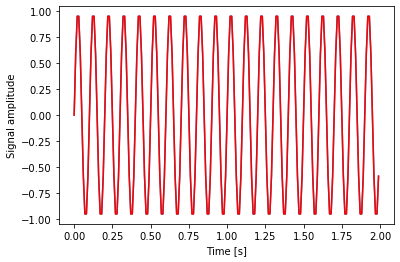

In [3]:
freq = 10  # in Hertz
sample_rate = 100  # measurements/sec

time_vec = np.linspace(0, 2, 2 * sample_rate, endpoint=False)
signal = np.sin(freq * 2 * np.pi * time_vec)

fig, ax = plt.subplots()
ax.plot(time_vec, signal)
ax.plot(time_vec, -1 * time_reversed_copy(signal), 'r')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude');

In [4]:
print(fftpack.fftfreq(10))

[ 0.   0.1  0.2  0.3  0.4 -0.5 -0.4 -0.3 -0.2 -0.1]


(-5, 110)

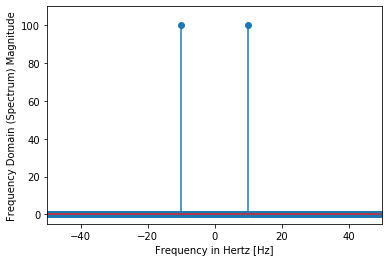

In [6]:
X = fftpack.fft(signal)
freqs = fftpack.fftfreq(len(signal)) * sample_rate

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X), use_line_collection=True)
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-sample_rate / 2, sample_rate / 2)
ax.set_ylim(-5, 110)

Alright, let's run this on some sound.

In [7]:
from IPython.display import Audio
Audio('clapping.wav')

In [45]:
from scipy.io import wavfile

rate, audio = wavfile.read('clapping.wav')

length_in_secs = audio.shape[0] / rate

print(f"audio.shape = {audio.shape}, rate = {rate}")
print(f"length of recording in seconds = {length_in_secs}")

audio.shape = (48128,), rate = 48000
length of recording in seconds = 1.0026666666666666


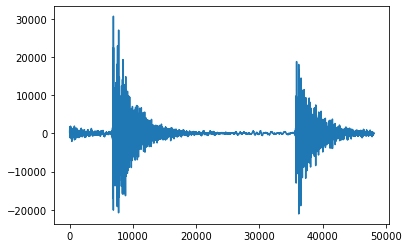

In [10]:
plt.plot(audio)

In [11]:
len(audio)

48128

We could compute slices manually,

In [23]:
SLICE_LENGTH = 1024
SLICE_STEP = 100

slice_starts = range(0, len(audio) - SLICE_LENGTH + 1, SLICE_STEP)
slices_manual = [audio[start:start + SLICE_LENGTH] for start in slice_starts]

but better not.

In [25]:
from skimage import util

slices = util.view_as_windows(audio, window_shape=(SLICE_LENGTH,), step=SLICE_STEP)

In [34]:
slices.shape

(472, 1024)

The Hanning window is just an upside down, translated cosine.

(1024,)


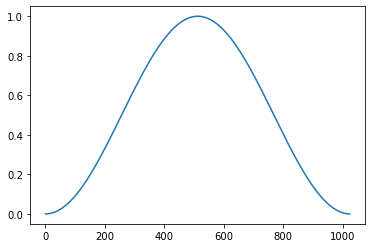

In [16]:
window = np.hanning(SLICE_LENGTH + 1)[:-1]
print(window.shape)
plt.plot(window)

Smooth each slice using the Hanning window.

In [35]:
smoothed_slices = slices * window

In [54]:
spectrum = np.fft.fft(smoothed_slices.T, axis=0)  #[:SLICE_LENGTH // 2 + 1:-1]
spectrum.shape

(1024, 472)

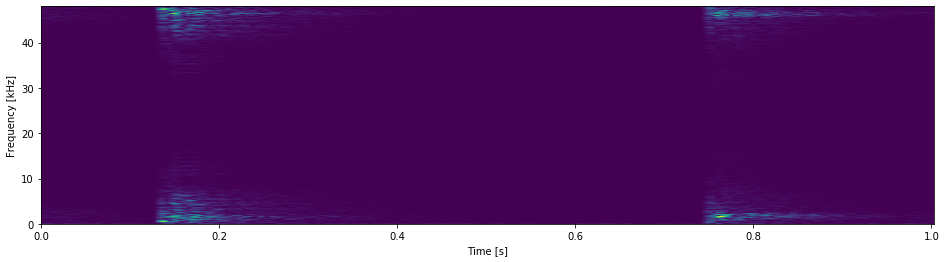

In [53]:
fig, axes = plt.subplots(figsize=(16, 4))
axes.imshow(np.abs(spectrum), extent=(0, length_in_secs, 0, rate / 1_000))
axes.axis('tight')
axes.set_ylabel('Frequency [kHz]')
axes.set_xlabel('Time [s]');

In [41]:
spectrum[:5, :5]

array([[-50153.80215283    +0.j        , -30051.48942233    +0.j        ,
         -8589.08618784    +0.j        ,   9205.6228637     +0.j        ,
         19957.20683349    +0.j        ],
       [ 34951.0168835 +40975.57107427j,   3008.40677168+39250.43892373j,
        -12004.82523139+19336.59472922j,  -8409.25371234 +6451.68550351j,
         -5457.95515066 +8003.30900404j],
       [-16026.8618893 -11168.04681551j,  -2546.96059596-38863.81985613j,
         46441.44863288-15625.28004823j,  15862.50540974+45747.31801104j,
        -47859.12588374 +7859.08546724j],
       [ -6538.06821505-56292.41090974j,  60390.39057812+28436.99692673j,
        -60757.48223118+49283.21742805j, -29737.19613243-80476.41274634j,
         83839.19018203 -8426.60534281j],
       [ 14402.95078398+59999.97167619j, -55024.6189714 -18488.39622178j,
         37346.5752454 -38205.10863779j,  18615.7016931 +46861.23739125j,
        -48084.57458595 -3811.42995209j]])

Scipy also has a FFT implementation. It should be equivalent to the one we get in numpy. Checking against our data, we see it's effectively identical.

In [52]:
scipy_fft_spectrum = fftpack.fft(smoothed_slices.T, axis=0)
np.max(abs(spectrum - scipy_fft_spectrum))

2.6031257322754127e-10

In [39]:
np.array([-2, -1, 0, 1 ,2])[:(5//2) + 1: -1]

array([2])

In [43]:
np.array(range(-5, 5))[:(len(range(-5, 5))//2) + 1: -1]

array([4, 3, 2])

In [55]:
list(range(10))[::-1]

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [56]:
list(range(10))[:5:-1]

[9, 8, 7, 6]

In [57]:
list(range(10))[5::-1]

[5, 4, 3, 2, 1, 0]

## Appendix: the Discrete Fourier Transform

The Discrete Fourier Transform is defined as follows:

\begin{align}
F({x_n})_k = \sum_{n=0}^{N-1}{x_n e^{-i\frac{2\pi}{N}kn}}
\end{align}

One thing that sticks out is the negative sign in the argument to the exponential. Why is that there?

It's convention. In particular, it means that the $k$th element of the DFT of the pure signal $x_n = \exp(i2\pi kn / N)$ is $N$ and not $-N$;

\begin{align}
\sum_{n=0}^{N-1}{x_n e^{-i\frac{2\pi}{N}kn}} = \sum_{n=0}^{N-1}{e^{i\frac{2\pi}{N}(kn-kn)}} = N
\end{align}

but 

\begin{align}
\sum_{n=0}^{N-1}{x_n e^{i\frac{2\pi}{N}kn}} = \sum_{n=0}^{N-1}{e^{i\frac{2\pi}{N}\cdot 2kn}}
\end{align}
